In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from PIL import Image

def afficher_resultats(frame, predictions):
    # Parcourir les prédictions et afficher les résultats sur la frame
    for prediction in predictions:
        # Récupérer le label de la prédiction
        #label = prediction['label']  # Supposons que vous avez un label pour chaque signe
        # Sélectionner l'index de la classe avec la probabilité la plus élevée
        index_classe_max = predictions.argmax()

        # Obtenir la probabilité de la classe prédite en pourcentage
        probabilite_max = predictions.max() * 100

        # Ajouter le label comme texte sur la frame
        # Convertir le label en chaîne de caractères (str) si nécessaire
        label = str(index_classe_max)

        # Ajouter le label comme texte sur la frame
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    return frame


# Chemin vers la vidéo sur Google Drive
video_path = '/content/drive/MyDrive/ASL/ABCD.mp4'

# Charger le modèle enregistré
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Model6/SignLanguageALSClassifier16.h5")

# Ouvrez la vidéo
cap = cv2.VideoCapture(video_path)

# Boucle à travers les frames de la vidéo
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    # Redimensionner l'image selon les besoins du modèle
    image_resized = cv2.resize(frame, (224, 224))

    # Convertir l'image en tableau numpy et prétraiter l'image
    image_array = np.array(image_resized)
    image_array = tf.keras.applications.mobilenet_v3.preprocess_input(image_array)

    # Effectuer la prédiction
    predictions = model.predict(np.expand_dims(image_array, axis=0))

    # Afficher les résultats sur la frame
    frame_with_results = afficher_resultats(frame, predictions)

    # Afficher la frame avec les résultats
    from google.colab.patches import cv2_imshow

    # Afficher la frame avec les résultats
    cv2_imshow(frame_with_results)


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
cv2.destroyAllWindows()



Output hidden; open in https://colab.research.google.com to view.

TEST MODEL ET TRADUCTION

1/1 [==============================] - 0s 64ms/step
Prédictions (en français) : SALUT
Traduction (en anglais) : CIAO
Les prédictions ont été enregistrées dans : /content/predictions.txt


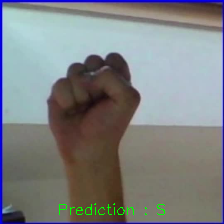

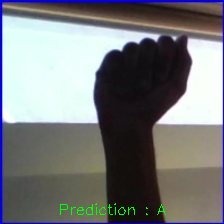

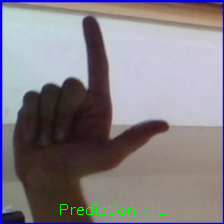

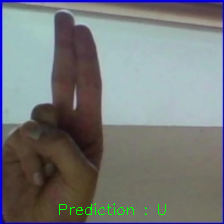

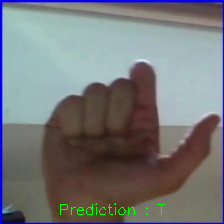

In [59]:
import cv2
import tensorflow as tf
import numpy as np
import subprocess
import os
from googletrans import Translator

from google.colab.patches import cv2_imshow

# Charger le modèle
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Model6/SignLanguageALSClassifier16.h5")

# Chemin vers la vidéo sur Google Drive
video_path = '/content/drive/MyDrive/ASL/SALUT.mp4'

# Chemin pour enregistrer les images extraites
output_path = '/content/extracted_images/'

# Créer le répertoire pour les images extraites s'il n'existe pas
os.makedirs(output_path, exist_ok=True)

# Commande ffmpeg pour extraire des images uniques de la vidéo sans redondance
ffmpeg_command = [
    'ffmpeg', '-i', video_path, '-vf', 'mpdecimate,setpts=N/FRAME_RATE/TB', output_path + 'image%d.jpg'
]

# Exécuter la commande ffmpeg pour supprimer la redondance des images
subprocess.call(ffmpeg_command)

# Liste pour stocker les images extraites dans l'ordre de séquence de la vidéo
images = []

# Ouvrir la vidéo pour obtenir le nombre total de frames
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

# Boucle à travers les frames extraites de la vidéo
for i in range(total_frames):
    # Construire le chemin de l'image
    image_path = os.path.join(output_path, f'image{i}.jpg')

    # Vérifier si le fichier existe
    if not os.path.exists(image_path):
        #print(f"Le fichier {image_path} n'existe pas.")
        continue

    # Lire l'image
    image = cv2.imread(image_path)

    # Vérifier si l'image est valide
    if image is None or image.size == 0:
        print(f"L'image {image_path} est vide ou corrompue. Ignorer.")
        continue

    # Redimensionner l'image selon les besoins du modèle
    image_resized = cv2.resize(image, (224, 224))

    # Ajouter l'image à la liste
    images.append(image_resized)


# Liste pour stocker les prédictions des lettres
predictions_list = []

# Boucle à travers les images extraites dans l'ordre de séquence de la vidéo
for image in images:
    # Convertir l'image en tableau numpy et prétraiter l'image
    image_array = np.array(image)
    image_array = tf.keras.applications.mobilenet_v3.preprocess_input(image_array)

    # Effectuer la prédiction
    predictions = model.predict(np.expand_dims(image_array, axis=0))

    # Obtenir la classe prédite
    classe_predite = np.argmax(predictions[0])

    # Obtenir la lettre correspondant à la classe prédite
    lettre_predite = chr(65 + classe_predite) if classe_predite != 28 else ' ' # A = 65 dans la table ASCII

    # Ajouter la lettre prédite à la liste des prédictions
    predictions_list.append(lettre_predite)

# Convertir les prédictions en texte
predicted_text = ''.join(predictions_list)

# Afficher les prédictions
print("Prédictions (en français) :", predicted_text)

# Traduire les prédictions en anglais
translator = Translator()
translated_text = translator.translate(predicted_text, src='fr', dest='it').text
print("Traduction (en anglais) :", translated_text)

# Créer un fichier texte pour enregistrer les prédictions et leur traduction
output_file_path = '/content/predictions.txt'
with open(output_file_path, 'w') as f:
    f.write("Prédictions (en français) : " + predicted_text + "\n")
    f.write("Traduction (en anglais) : " + translated_text)

# Afficher le chemin d'accès du fichier texte
print("Les prédictions ont été enregistrées dans :", output_file_path)

# Vider le répertoire des images extraites avant de commencer
# Fonction pour vider un répertoire
def clear_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                clear_directory(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print('Erreur lors de la suppression du fichier :', e)
clear_directory(output_path)

# Afficher les images avec les prédictions
for image, lettre_predite in zip(images, predictions_list):
    # Afficher la prédiction sur l'image
    label = f"Prediction : {lettre_predite}"
    image_with_label = np.copy(image)

    # Redimensionner la taille du texte pour s'adapter à l'image
    scale = 0.5
    thickness = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size = cv2.getTextSize(label, font, scale, thickness)[0]

    # Position de départ du texte
    text_x = (image_with_label.shape[1] - text_size[0]) // 2
    text_y = image_with_label.shape[0] - 10

    # Ajouter la prédiction à l'image
    cv2.putText(image_with_label, label, (text_x, text_y), font, scale, (0, 255, 0), thickness)

    # Afficher l'image avec la prédiction dans Colab
    cv2_imshow(image_with_label)


generer des videos via ffmpeg /!\

In [45]:
import subprocess
import os

# Chemin vers le dossier contenant les images des lettres
input_folder = '/content/drive/MyDrive/ASL/asl_alphabet_test/asl_alphabet_test/'

# Dossier pour stocker les images temporaires
temp_images_folder = '/content/tempImg'

# Nom de la vidéo de sortie
output_video = '/content/OUTPUT/MAMAN.mp4'

# Fonction pour générer le chemin complet de l'image pour une lettre donnée
def get_image_path(lettre):
    return os.path.join(input_folder, f"{lettre}_test.jpg")

# Fonction pour générer une vidéo à partir d'un mot donné
def generate_video_from_word(word):
    # Créer le dossier temporaire pour stocker les images
    os.makedirs(temp_images_folder, exist_ok=True)

    # Liste pour stocker les chemins des images à concaténer
    images_list = []

    # Boucle à travers chaque lettre du mot
    for lettre in word:
        # Générer le chemin complet de l'image pour la lettre donnée
        image_path = get_image_path(lettre)
        if os.path.exists(image_path):
            images_list.append(image_path)
        else:
            print(f"Image manquante pour la lettre '{lettre}'. Ignorer.")

    # Créer une liste de commandes ffmpeg pour concaténer les images
    ffmpeg_commands = [
        ['ffmpeg', '-i', image, '-vf', 'fps=25', '-pix_fmt', 'yuv420p', '-vf', 'scale=720:480', '-r', '25', '-y', os.path.join(temp_images_folder, f'image_{i}.mp4')]
        for i, image in enumerate(images_list)
    ]

    # Concaténer les vidéos temporaires en une seule vidéo de sortie
    concat_command = ['ffmpeg']
    for command in ffmpeg_commands:
        concat_command.extend(['-i', command[-1]])

    concat_command.extend(['-filter_complex', 'concat=n=' + str(len(ffmpeg_commands)) + ':v=1:a=0', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', '-y', output_video])

    # Exécuter la commande ffmpeg pour concaténer les vidéos
    subprocess.call(concat_command)

    # Supprimer le dossier temporaire
    os.rmdir(temp_images_folder)

    print("La vidéo a été générée avec succès :", output_video)

# Exemple d'utilisation : générer une vidéo à partir du mot "HELLO"
generate_video_from_word("MA")


La vidéo a été générée avec succès : /content/OUTPUT/MAMAN.mp4
